IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



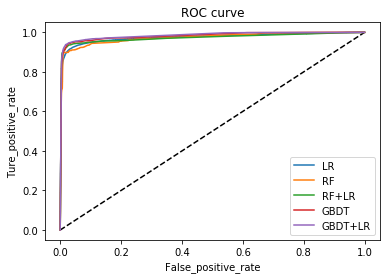

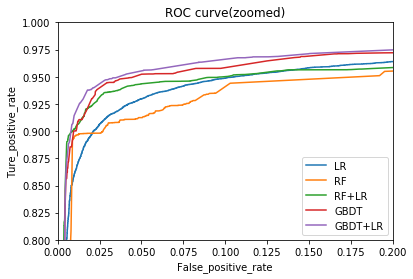

In [2]:
"""
GBDT+LR 算法demo
随机生成二分类样本8w个，样本特征20个
采用RF，RF+LR，GBDT，GBDT+LR进行二分类预测
"""
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10  # The number of trees in the forest
#生成样本集
X,y = make_classification(n_samples=80000,n_features=20)
print(X)
print(len(X[0]))
#将样本集分为测试集合训练集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5)
#训练集在分为两个部分（GBDT/RF,LR）
X_train_f,X_train_lr,y_train_f,y_train_lr = train_test_split(X_train,y_train,test_size=0.5)

#基于随机森林的监督变换
rf = RandomForestClassifier(max_depth=3,n_estimators=n_estimator)
rf.fit(X_train_f,y_train_f)
# OneHot 编码
rf_enc = OneHotEncoder(categories='auto')
rf_enc.fit(rf.apply(X_train_f))
#使用OneHot编码作为特征，训练LR
rf_lm = LogisticRegression(solver='lbfgs',max_iter=1000)
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)),y_train_lr)
#使用LR进行预测
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:,1]
fpr_rf_lm,tpr_rf_lm, thresholds = roc_curve(y_test,y_pred_rf_lm)  #fp,tp,threshold

#基于GBDT监督变换
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(X_train_f,y_train_f)
#OneHot编码
grd_enc = OneHotEncoder(categories='auto')

np.set_printoptions(threshold=np.inf)  
#np.inf无穷大，float64格式能表示的最大的数，±(1−2−53)∗21024=±1.79769×10308
#set_printoptions设置最大显示的行数
grd_enc.fit(grd.apply(X_train_f)[:,:,0])
#print(grd_enc.get_feature_names()) #查看每一列对应的特征
#使用OneHot编码作为特征，训练LR
grd_lm = LogisticRegression(solver='lbfgs',max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:,:,0]),y_train_lr)
#使用lr预测
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:,:,0]))[:,1]
fpr_grd_lm , tpr_grd_lm ,thresholds = roc_curve(y_test,y_pred_grd_lm)



#直接使用GBDT
y_pred_grd = grd.predict_proba(X_test)[:,1]
fpr_grd,tpr_grd,thresholds_grd = roc_curve(y_test,y_pred_grd)

#直接使用RF
rf1 = RandomForestClassifier(max_depth=3,n_estimators=n_estimator)
rf1.fit(X_train,y_train)
y_pred_rf = rf1.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,thresholds_skl = roc_curve(y_test,y_pred_rf)

#直接使用LR
LR = LogisticRegression(n_jobs=4,C=0.1,penalty='l2')
LR.fit(X_train,y_train)
y_pred = LR.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,threshols_lr = roc_curve(y_test,y_pred)
#auc = roc_auc_score(y_test,y_pred)
#print('logisticRegression:',ruc)

plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_lr,tpr_lr,label='LR')
plt.plot(fpr_rf,tpr_rf,label='RF')
plt.plot(fpr_rf_lm,tpr_rf_lm,label='RF+LR')
plt.plot(fpr_grd,tpr_grd,label='GBDT')
plt.plot(fpr_grd_lm,tpr_grd_lm,label='GBDT+LR')
plt.title('ROC curve')
plt.xlabel('False_positive_rate')
plt.ylabel('Ture_positive_rate')
plt.legend(loc='best')
plt.show()

#左上角放大显示
plt.figure(2)
plt.xlim(0,0.2)
plt.ylim(0.8,1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_lr,tpr_lr,label='LR')
plt.plot(fpr_rf,tpr_rf,label='RF')
plt.plot(fpr_rf_lm,tpr_rf_lm,label='RF+LR')
plt.plot(fpr_grd,tpr_grd,label='GBDT')
plt.plot(fpr_grd_lm,tpr_grd_lm,label='GBDT+LR')
plt.xlabel('False_positive_rate')
plt.ylabel('Ture_positive_rate')
plt.title('ROC curve(zoomed)')
plt.legend(loc='best')
plt.show()